In [164]:
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import resnet50
from timeit import default_timer as timer
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Image transformations
image_transforms = {
    # Train uses data augmentation (not implemented)
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Test set does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [125]:
#keep the images as PIL so they can be transformed later
def ims(da_path, da_arr):
    for path in da_path:
        image = cv2.imread(path)
        image_from_array = Image.fromarray(image, 'RGB')
        da_arr.append(image_from_array)
    return da_arr

In [127]:
df = pd.read_csv('Train.csv')

paths1 = df[(df['ClassId'] ==1)]['Path'].values
paths2 = df[(df['ClassId'] ==2)]['Path'].values
paths3 = df[(df['ClassId'] ==3)]['Path'].values
paths4 = df[(df['ClassId'] ==4)]['Path'].values
paths5 = df[(df['ClassId'] ==5)]['Path'].values

    
class1_arrs = []
class1_arrs = ims(paths1, class1_arrs)

class2_arrs = []
class2_arrs = ims(paths2, class2_arrs)

class3_arrs = []
class3_arrs = ims(paths3, class3_arrs)

class4_arrs = []
class4_arrs = ims(paths4, class4_arrs)

class5_arrs = []
class5_arrs = ims(paths5, class5_arrs)

In [157]:
X = class1_arrs + class2_arrs + class3_arrs + class4_arrs + class5_arrs
y = len(class1_arrs)*[0] + len(class2_arrs)*[1] + len(class3_arrs)*[2] + len(class4_arrs)*[3] + len(class5_arrs)*[4]

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =0)

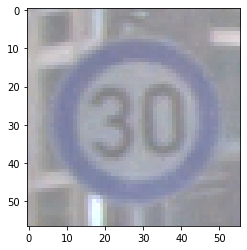

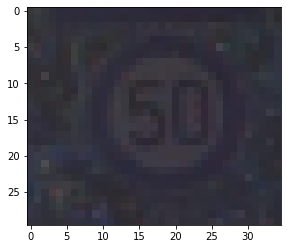

In [165]:
#image before transform
plt.imshow(class1_arrs[0])
plt.show()
plt.imshow(class2_arrs[0])
plt.show()

In [135]:
for i in range(len(X_train)):
    X_train[i] = image_transforms['train'](X_train[i])
for i in range(len(X_test)):
    X_test[i] = image_transforms['test'](X_test[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


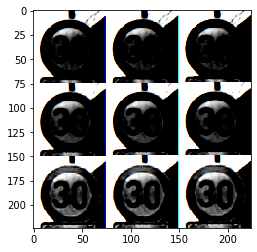

In [136]:
#image after transform
plt.imshow(X_train[0].view(224,224,3))
plt.show()

In [138]:
#create training and testing sets
train_data = [(X_train[i], y_train[i]) for i in range(len(X_train))]
test_data = [(X_test[i], y_test[i]) for i in range(len(X_test))]
print(len(train_data))

trainset = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testset = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)

7776


<h3> Begin Transfer Learning

In [139]:
res3_model = resnet50(pretrained=True)

In [140]:
res3_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [141]:
#freeze weights
for param in res3_model.parameters():
    param.requires_grad = False

In [142]:
inputs = res3_model.fc.in_features
inputs

2048

In [147]:
res3_model.fc = nn.Sequential(nn.Linear(inputs, 16), nn.ReLU(), nn.Linear(16, 5), nn.LogSoftmax(dim=1))

In [148]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res3_model.parameters(), lr=.0003)

In [149]:
print('Starting Training from Scratch.\n')

n_epochs = 8
train_loss = []
train_acc = []
for epoch in range(n_epochs):
    start = timer()
    
    running_loss = 0
    running_correct = 0
    
    for data, targets in trainset:
        #data = data.to(device)
        #targets = targets.to(device)
        # Generate predictions
        outputs = res3_model(data)
        # Calculate loss
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
        # Loss and accuracy calc
        
        preds = torch.argmax(outputs, axis=1)
        running_loss += loss.item()
        running_correct += torch.sum(preds == targets.data)
    epoch_loss = running_loss/len(trainset.dataset)
    epoch_acc = running_correct.float()/ len(trainset.dataset)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    
    print(f'Epoch: {epoch + 1} \t Training Loss: {epoch_loss:.3f} \t Time Elapsed in Epoch: {timer()-start:.2f}')

Starting Training from Scratch.

Epoch: 1 	 Training Loss: 0.170 	 Time Elapsed in Epoch: 1852.57
Epoch: 2 	 Training Loss: 0.138 	 Time Elapsed in Epoch: 1862.59
Epoch: 3 	 Training Loss: 0.124 	 Time Elapsed in Epoch: 1837.18
Epoch: 4 	 Training Loss: 0.116 	 Time Elapsed in Epoch: 1807.10
Epoch: 5 	 Training Loss: 0.109 	 Time Elapsed in Epoch: 1810.62
Epoch: 6 	 Training Loss: 0.107 	 Time Elapsed in Epoch: 1802.04
Epoch: 7 	 Training Loss: 0.104 	 Time Elapsed in Epoch: 1807.09
Epoch: 8 	 Training Loss: 0.101 	 Time Elapsed in Epoch: 1806.71


In [150]:
#epochs=8, nn.Sequential(Linear(inputs, 10), ReLU, Linear(10,2), softmax) with lr = 0.0001:::: 82%, 80%

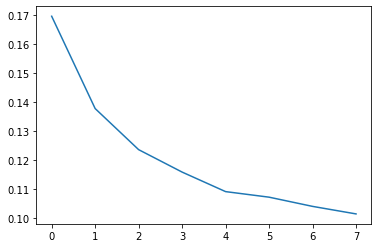

In [151]:
plt.plot(train_loss)

tensor(0.6969)

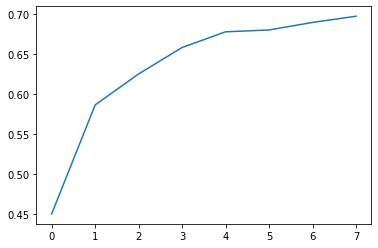

In [152]:
plt.plot(train_acc)
train_acc[-1]

<h2> TODO: TESTING SET

In [153]:
correct = 0
for data, target in testset:
    data = data.to(device)
    target = target.to(device)
    preds = res3_model(data)
    preds = torch.argmax(preds, axis=1)
    correct += torch.sum(preds==target.data)
    
correct.item()/len(testset.dataset)

0.6877572016460906

In [154]:
#for training
correct = 0
total = 0

with torch.no_grad():
    for data in trainset:
        X,y = data
        output = res3_model(X)
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct+=1
            total+=1

print('Train accuracy', round(correct/total, 3))

Train accuracy 0.697


In [155]:
#for test
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X,y = data
        output = res3_model(X)
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct+=1
            total+=1

print('Test accuracy', round(correct/total, 3))

Test accuracy 0.697
